In [1]:
import torch.nn as nn
import torch

class unet(nn.Module):
    def __init__(self):
        super(unet,self).__init__()
        # input image
        self.inputLayer = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)

        # down layers
        self.downLayer1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )
        self.downLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )
        self.downLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )

        # up layers
        self.upLayer3_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upLayer3_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True)
        )

        self.upLayer2_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upLayer2_2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True)
        )

        self.upLayer1_1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upLayer1_2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True)
        )

        # output layer
        self.outputLayer = nn.Conv2d(32, 9, kernel_size=1, stride=1)

        # combine

    def forward(self,image):
        input = self.inputLayer(image)

        # down
        down1 = self.downLayer1(input)
        down2 = self.downLayer2(down1)
        down3 = self.downLayer3(down2)

        # up
        up3_0 = self.upLayer3_1(down3)
        up3_1 = torch.cat([up3_0, down2], dim=1)
        up3 = self.upLayer3_2(up3_1)

        up2_0 = self.upLayer2_1(up3)
        up2_1 = torch.cat([up2_0, down1], dim=1)
        up2 = self.upLayer2_2(up2_1)

        up1_0 = self.upLayer1_1(up2)
        up1_1 = torch.cat([up1_0, input], dim=1)
        up1 = self.upLayer1_2(up1_1)

        # output
        output = self.outputLayer(up1)

        return output

In [2]:
def normalization(array, is_rgb):
    dst = array
    if is_rgb:
        dst = (dst - 0.5) / 0.5
    return dst


In [3]:
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import skimage.transform as transform
from skimage.measure import find_contours as FC
from skimage.draw import polygon as pg
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
path = "ara2012/test"
imagesName = sorted([join(path,fn) for fn in listdir(path)])

In [5]:
images = [cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB) for fn in imagesName if fn.endswith("rgb.png")]
labels = [cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY) for fn in imagesName if fn.endswith("label.png")]

In [6]:
def each_label(labels):
    # each true label
    each = []
    for index, value in enumerate(np.unique(labels)[1:]):
        binary = np.zeros(labels.shape)
        binary[labels == value] = 1
        each.append(binary)
    return each

In [7]:
def generalize_label(ypred):
    # generalize output label image
    min_point = [65] * (ypred.shape[2] - 1)
    ob_i = 1
    max_pred = np.argmax(ypred, axis=0)
    output = np.zeros(ypred[0, :, :].shape)
    for j in range(1, ypred.shape[0]):
        edges = FC(max_pred==j, 0.5)
        for e in edges:
            rr, cc = pg(e[:, 0], e[:, 1])
            if len(rr) > min_point[j - 1]:
                output[rr, cc] = ob_i
                ob_i += 1
    return output

In [8]:
def symmetric_best_dice1(sgt, sdm):
    def best_dice(gt, dm):
        if len(gt) == 0:
            return 0
        result = 0 
        for a in gt:
            best_dice = 0
            for b in dm:
                dice = 2 * float(np.sum(a * b)) / float(np.sum(a) + np.sum(b))
                if dice > best_dice:
                    best_dice = dice
            result = result + best_dice
        return result / len(gt)   
    m = best_dice(sgt, sdm)
    n = best_dice(sdm, sgt)  
    return np.min((m,n))

In [9]:
modelpath = "ara2012 model5000.t7"
model = unet().to(device)
model.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
model.eval()
SBD = []

for i in range(len(images)):
    # generalize predicted y
    img = images[i]

    img = transform.resize(img, (248, 248))
    img = normalization(img, True)
    img = torch.from_numpy(np.expand_dims(img.transpose(2, 0, 1), 0)).float().to(device)
    
    y = model(img)
    
    ylabel = cv2.resize(labels[i], (248, 248), interpolation=cv2.INTER_NEAREST)        
    ypred = y.detach().cpu().numpy()[0]
    
    ytruth = each_label(ylabel)
    output = generalize_label(ypred)
    yeach = each_label(output)
    
    sbd = symmetric_best_dice1(ytruth, yeach)

    SBD.append(sbd)
mean_value = np.array(SBD).mean(axis=0)
std_value = np.array(SBD).std(axis=0)
print(mean_value*100, std_value*100)

76.41756366525114 6.567207645663095


In [10]:
import skimage.transform as transform
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F

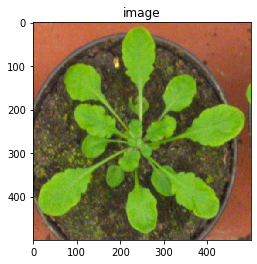

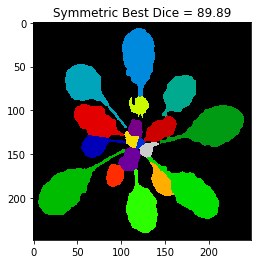

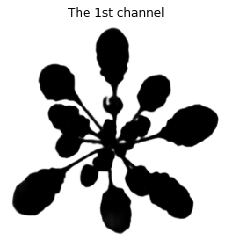

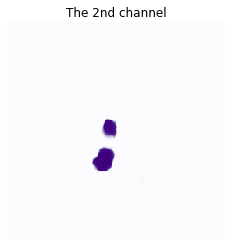

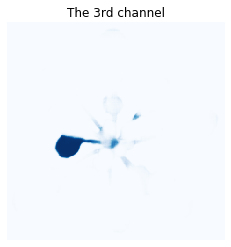

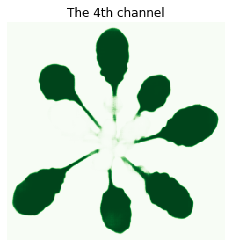

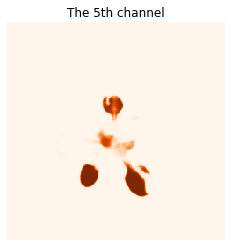

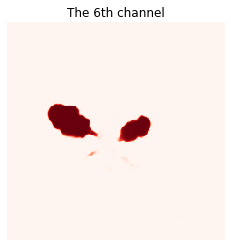

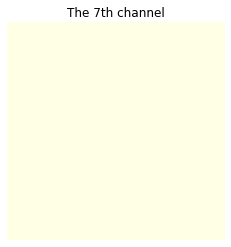

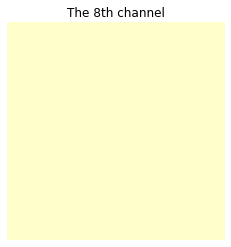

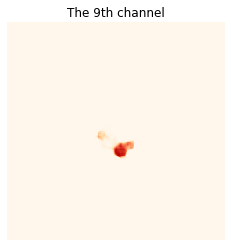

In [11]:
ara2012 = "Ara2012/test/ara2012_plant023_rgb.png"
ara2013 = "Ara2013/test/ara2013_plant006_rgb.png"
tobacco = "tobacco/test/tobacco_plant034_rgb.png"
ara2012label = "Ara2012/test/ara2012_plant023_label.png"
imgpath = ara2012

model = unet().to(device)
model.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
model.eval()

img_test = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
img_train = transform.resize(img_test, (248, 248))
img_train = normalization(img_train, True)
img_train = torch.from_numpy(np.expand_dims(img_train.transpose(2, 0, 1), 0)).float().to(device)    
pred = model(img_train)
y = pred.detach().cpu().numpy()[0]

# visualize(img_test, y)
plt.figure()
plt.title("image")
plt.imshow(img_test)
plt.show()

label_test = cv2.resize(cv2.cvtColor(cv2.imread(ara2012label), cv2.COLOR_BGR2GRAY), (248, 248), interpolation=cv2.INTER_NEAREST)
ytruth = each_label(label_test)
output = generalize_label(y)
yeach = each_label(output)
SBD = symmetric_best_dice1(ytruth, yeach)*100

plt.figure()

plt.title("Symmetric Best Dice = %.2f"%SBD)
plt.imshow(output, cmap=plt.cm.nipy_spectral)
# plt.axis("off")
# plt.savefig("samples.png")
plt.show()

# channels
sf_y = F.softmax(torch.from_numpy(y), dim=0).numpy()
colorList = [plt.cm.gray, plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges,
                plt.cm.Reds, plt.cm.YlOrBr, plt.cm.YlOrRd, plt.cm.OrRd]
for i in range(y.shape[0]):
    plt.figure()
    if i == 0:
        plt.title("The 1st channel")
    elif i == 1:
         plt.title("The 2nd channel")
    elif i == 2:
         plt.title("The 3rd channel")
    else:
        plt.title("The %dth channel"%(i+1))
    plt.imshow(sf_y[i, :, :], vmin=0, vmax=1, cmap=colorList[i])
    plt.axis("off")
    plt.savefig("samples C"+str(i+1)+".png")
    plt.show()